In [3]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import powerlaw as pl
import snntorch
import torch
from snntorch import surrogate
from scipy.optimize import curve_fit

sys.path.append('../')
from src import data
from src import heavy_tail as ht
from src import plot_params
from src.spiking_neural_network import Snn

In [5]:
database = 'fashion_mnist'
_, _, _, _, device = data.set_loader_device(database)

dataset_name = 'train_set'
imgs_labels = torch.load(
    f'../data/imgs_labels/{database}_{dataset_name}_imgs_labels.pth'
)

n = 300
num_units_layers = [784, n, n, 10]
spk_neuron = snntorch.Leaky(
    beta=0.5,
    threshold=1,
    reset_mechanism='subtract',
    spike_grad=surrogate.fast_sigmoid(slope=25)
)

model = Snn(spk_neuron, num_units_layers).to(device=device)
checkpoint = torch.load(f'../data/trained_model/{n}_{n}_{database}_snn.pth')

In [6]:
def fast_transition_movie(imgs_labels: list, delta_t: int):
    frames = list()
    labels = np.random.randint(10, size=1000)
    for l in labels:
        # We randomly choice samples over dataset.
        samples = np.random.randint(4000, size=delta_t)
        for t in samples:
            frames +=  [imgs_labels[str(l)][t]]

    return frames 


In [7]:
frames = fast_transition_movie(imgs_labels, delta_t=30)
num_frames = len(frames)
print('num_frames', num_frames)

# Movie presentation.
layers = model.movie(checkpoint, frames, device)

# Data collection for each layer.
# Number of variables: rho, mem, cur.
num_variable = 3
layer_1 = np.zeros((num_frames, num_variable, model.num_units_layers[1]))
layer_2 = np.zeros((num_frames, num_variable, model.num_units_layers[2]))
layer_3 = np.zeros((num_frames, num_variable, model.num_units_layers[3]))

for t in range(num_frames):
    layer_1[t,:] = layers[t][0][:]
    layer_2[t,:] = layers[t][1][:]
    layer_3[t,:] = layers[t][2][:]

# Sum with respect to neurons of the layer.
layer_1_sum = np.sum(layer_1, axis=-1)
layer_2_sum = np.sum(layer_2, axis=-1)

# Spike activity is the number of active neurons.
spk_activity = np.stack((layer_1_sum[:,0],layer_2_sum[:,0]))

num_frames 30000


In [8]:
total_activity =  spk_activity[0] + spk_activity[1]
avalanches_s, avalanches_t = ht.avalanches_s_t(total_activity, 0.9)

s, pdf_s = pl.pdf(avalanches_s)
t, pdf_t = pl.pdf(avalanches_t)

popt_s, pcov_s = curve_fit(ht.exponential_pdf, s[:-1], pdf_s, p0=[0.5])
perr_s = np.sqrt(np.diag(pcov_s))

popt_t, pcov_t = curve_fit(ht.exponential_pdf, t[:-1], pdf_t, p0=[0.5])
perr_t = np.sqrt(np.diag(pcov_t))

popt_couple, pcov_couple = curve_fit(ht.power_law_func, avalanches_t, avalanches_s, p0=[1, 1])
perr_couple = np.sqrt(np.diag(pcov_couple))

In [9]:
s_fit = pl.Fit(avalanches_s, xmin=20, xmax = 600, discrete=True)
s_tau = s_fit.alpha
s_sigma = s_fit.sigma

d_fit = pl.Fit(avalanches_t, discrete=True)
d_tau = d_fit.alpha
d_sigma = d_fit.sigma

gamma = (d_tau - 1) / (s_tau - 1)

Calculating best minimal value for power law fit


In [10]:
gamma

217.89561168555915

In [137]:
# s_x, pdf_x = ht.freq_avalanches(avalanches_s)
# t_x, pdf_tx = ht.freq_avalanches(avalanches_t)

/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/jhdesantana/.virtualenvs/master/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


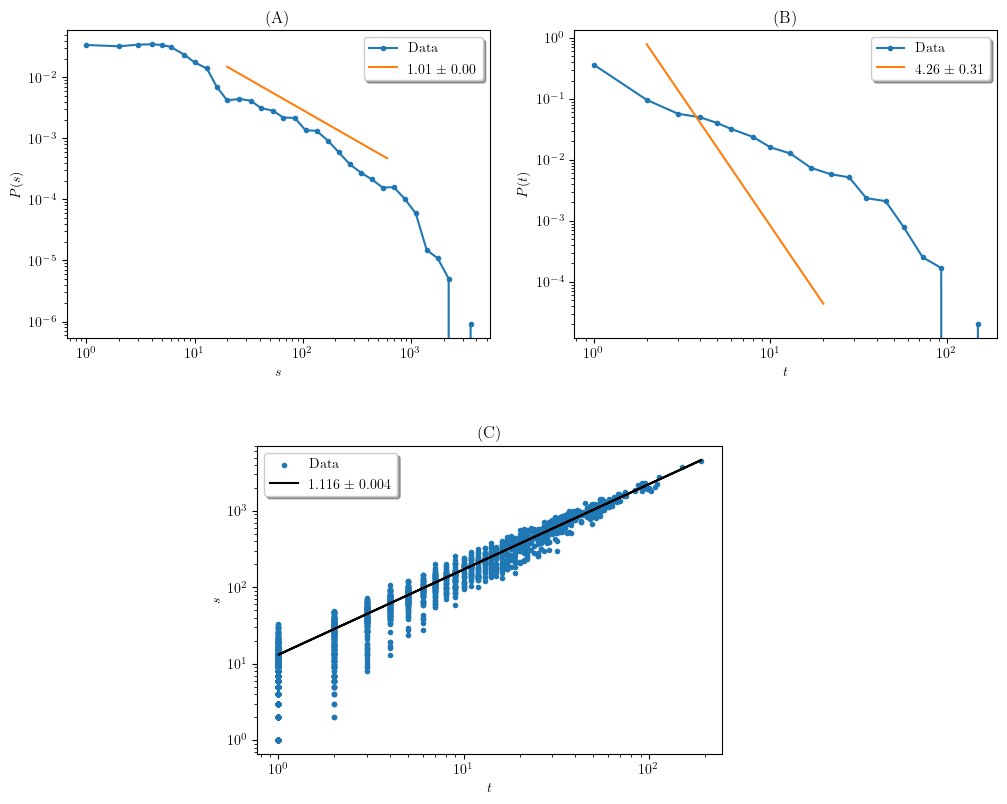

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
#
ax[0].plot(s[:-1], pdf_s, marker='.', label='Data')
srange = np.linspace(20, 600, 1000)
ax[0].plot(srange, ht.power_law_pdf(srange, s_tau), label=fr'{s_tau: .2f} $\pm$ {s_sigma: .2f}')
#ax[0].plot(s[:-1], ht.exponential_pdf(s[:-1], *popt_s), label='Fit')
#ax[0].plot(s_x, pdf_x)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$s$')
ax[0].set_ylabel(r'$P(s)$')
ax[0].set_title('(A)')
ax[0].legend()

ax[1].plot(t[:-1], pdf_t, marker='.', label='Data')
trange = np.linspace(2, 20, 1000)
ax[1].plot(trange, ht.power_law_pdf(trange, d_tau), label=fr'{d_tau: .2f} $\pm$ {d_sigma: .2f}')
#ax[1].plot(t[:-1], ht.exponential_pdf(t[:-1], *popt_t), label='Fit')
#ax[1].plot(t_x, pdf_tx)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$P(t)$')
ax[1].set_title('(B)')
ax[1].legend()


ax3 = ax[0].inset_axes([0.45, -1.35, 1.1, 1])

ax3.scatter(avalanches_t, avalanches_s, marker= '.', label='Data')
ax3.plot(avalanches_t, ht.power_law_func(avalanches_t, *popt_couple), color='k', label=fr'{popt_couple[1]: .3f} $\pm$ ${perr_couple[1]: .3f}$')
# ax3.plot(np.sort(avalanches_t), aval.power_func(np.sort(avalanches_t), popt_couple[0], gamma[1], popt_couple[2]), color='tab:orange')

#ax3.spines[['right', 'top']].set_visible(False)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel(r'$s$')
ax3.set_xlabel(r'$t$')
ax3.set_title('(C)')
ax3.legend()